In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import torch
import cv2
import numpy as np
import random
from options import DefaultConfig
opt = DefaultConfig()
#torch.cuda.set_device(opt.gpu_ids)
torch.manual_seed(opt.seed)
#torch.cuda.manual_seed(opt.seed)
#torch.cuda.manual_seed_all(opt.seed)
np.random.seed(opt.seed)
random.seed(opt.seed)
import sys
import os
import time
import pdb
from models.model import model
import torch
import torchvision
import torchvision.transforms as transforms
from scipy import interpolate
from utils.image_folder import ImageFolder
from utils import utils
from utils.utils import *
import matplotlib.pyplot as plt
from IPython.display import clear_output
from models import create_Inet
opt.sample_Ps = [1]
opt.I_path = 'snapshot/I_inter_L2_weighted_28.9.pkl'

1. 导入GPU包被注释
2. Inet维度
3. Inet加载到GPU
4. calc_batch_psnr 返回值类型
5. dataloader 改写

In [8]:
opt.dataroot_val = '/Users/zhangyiqian/Documents/course_files/research_project/davis'
dataset_val = ImageFolder(opt.dataroot_val, opt.num_frames, 
                       transform=transforms.Compose([
                                   transforms.Resize(opt.loadSize),
                                   transforms.CenterCrop(opt.fineSize),
                                   transforms.ToTensor()]))
dataset_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=opt.batch_size_val, shuffle=False)
dataset_val_size = len(dataset_val)
print('#validation videos = %d' % dataset_val_size)

#validation videos = 47


In [9]:
model = create_Inet(opt)
model.setup(opt)
model.eval()
pass

Interaction net is created
[Interaction net] loading Inet sccesses


TODO:
1. try to train the automatic colourisation first and then interactive
2. try to only use randomcrop
3. stack all the input because some spatial information might lose because of seperation input
4. downsamnpling optimsation in loss calculation

Done:
1. interactive colourisation training without fake_ab using lr: 0.0001
2. change lr to 0.000001
2. add fake_ab and lr is 0.00001

In [10]:
val_psnr = np.zeros((dataset_val_size, opt.num_frames-1))
for ii, data_raw_val in enumerate(dataset_loader_val):
    data_raw_val = torch.squeeze(data_raw_val, dim=0)
    # auto colourisartion
    opt.no_prev = True
    data_cpu_val = utils.get_colorization_data(data_raw_val, opt, p=opt.sample_p)
    # data_val = ToCuda(data_cpu_val)
    # data_val['prev'] = model.run_auto_colour(data_val)
    real_ab = data_cpu_val['ab'].numpy()
    new_click = torch.zeros_like(data_cpu_val['clicks']).numpy()
    new_click[:, 0, :, :] - 0.5 
    prev = torch.zeros_like(data_cpu_val['ab'])
    L_np = data_cpu_val['gray'].numpy()
    L_np = np.around(L_np * 255)
    
    # update first colourisation
    for i in range(real_ab.shape[0]-1):
        flow = cv2.calcOpticalFlowFarneback(L_np[i,0,:,:], L_np[i+1,0,:,:], None, 0.5, 3, 15, 3, 50, 1.2, 0).astype(np.int32)
        for x in range(flow.shape[0]):
            for y in range(flow.shape[1]):
                u = flow[x, y, 0]
                v = flow[x, y, 1]
                new_x = x+u
                new_y = y+v
                if new_x > 223:
                    new_x = 223
                if new_y > 223:
                    new_y = 223
                new_click[i+1, 1:, new_x, new_y] = real_ab[i, :, x, y]
                new_click[i+1, 0, new_x, new_y] = 0.5
    fake_ab_val = model(data_cpu_val['gray'][1:,:,:,:], torch.from_numpy(new_click[1:,:,:,:]), prev[1:,:,:,:])
    psnr = calc_batch_psnr(data_cpu_val['gray'][1:,:,:,:].detach(), data_cpu_val['ab'][1:,:,:,:].detach(), fake_ab_val.detach(), opt, False)
    val_psnr[ii,:] = psnr[:]
    #if ii == 2:
    #    break

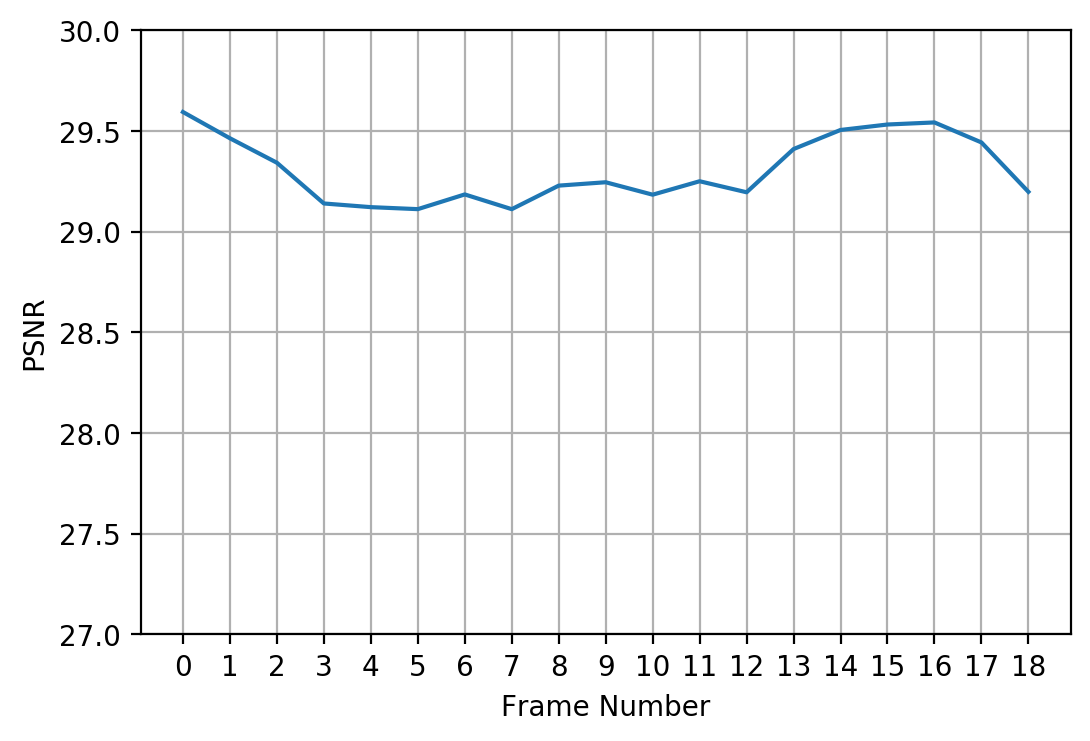

In [26]:
Y = np.mean(val_psnr, axis=0)
X = np.arange(19)
plt.rcParams['figure.dpi'] = 200
my_x_ticks = np.arange(19)
plt.xticks(my_x_ticks)
plt.ylim([27, 30])
plt.grid()
plt.xlabel('Frame Number')
plt.ylabel('PSNR')
plt.plot(X, Y)
plt.show()

In [12]:
np.mean(val_psnr)

29.306138637752042

26.439617934227186


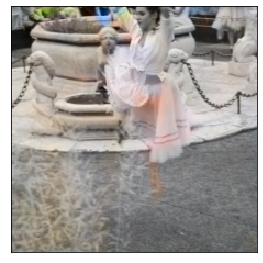

In [11]:
import matplotlib.pyplot as plt 
from skimage.transform import resize
import skimage

lightness = data_cpu_val['gray'][1:,:,:,:]#.numpy()
real_ab = data_cpu_val['ab'][1:,:,:,:]#.numpy()
fake_ab = fake_ab_val.detach() #.numpy()
fake_img = torch.cat((lightness, fake_ab), 1) 
real_img = torch.cat((lightness, real_ab), 1) 

# fake_img = fake_img.unsqueeze(0)  # [1, 224, 224, 3]
# real_img = real_img.unsqueeze(0)    # [1, 224, 224, 1]

fake_rgb = lab2rgb(fake_img, opt).detach().numpy()
real_rgb = lab2rgb(real_img, opt).detach().numpy()

idx = 4
img = real_rgb[idx,:,:,:].transpose(1,2,0)
img = fake_rgb[idx,:,:,:].transpose(1,2,0)
img = np.minimum(img, 1)
#img = resize(img, (1024, 1024))
skimage.io.imshow(img)
plt.xticks([])
plt.yticks([])
mse = np.mean((fake_rgb[idx, :, :, :] - real_rgb[idx, :, :, :]) ** 2 )
psnr = 10 * np.log10(1.0 / mse)
print(psnr)

In [ ]:
import matplotlib.pyplot as plt 
from skimage.transform import resize
import skimage

lightness = data_val['gray'][n1,:,:,:].cpu()
real_ab = data_val['ab'][n2,:,:,:].cpu()
fake_ab = fake_ab_val[0,:,:,:].cpu()
fake_img = torch.cat((lightness, fake_ab), 0) 
real_img = torch.cat((lightness, real_ab), 0) 

fake_img = fake_img.unsqueeze(0)  # [1, 224, 224, 3]
real_img = real_img.unsqueeze(0)    # [1, 224, 224, 1]

fake_rgb = lab2rgb(fake_img, opt).detach().numpy()
real_rgb = lab2rgb(real_img, opt).detach().numpy()

idx = 0
img = real_rgb[idx,:,:,:].transpose(1,2,0)
img = fake_rgb[idx,:,:,:].transpose(1,2,0)
img = np.minimum(img, 1)
img = resize(img, (1024, 1024))
skimage.io.imshow(img)
plt.xticks([])
plt.yticks([])
mse = np.mean((fake_rgb[idx, :, :, :] - real_rgb[idx, :, :, :]) ** 2 )
psnr = 10 * np.log10(1.0 / mse)
print(psnr)

In [ ]:
torch.__version__

In [ ]:
model.training